### Sentence Contradiction Classification 

### Introduction
Classify pairs of sentences as "contradiction," "entailment," or "neutral" based on their meaning. The task requires building a model that can understand semantic relationships between text pairs.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup

In [4]:
#Readling the datasets
df = pd.read_csv("/kaggle/input/mydearwason1/train.csv")
df.shape

(12120, 6)

### Exploratory Data Analysis (EDA):

In [5]:
df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [6]:
# Keep only rows where the language is English
df = df[df["language"] == "English"].reset_index(drop=True)

print("\nFiltered dataset with only English rows:")
print(df.head())



Filtered dataset with only English rows:
           id                                            premise  \
0  5130fd2cb5  and these comments were considered in formulat...   
1  5b72532a0b  These are issues that we wrestle with in pract...   
2  5622f0c60b  you know they can't really defend themselves l...   
3  fdcd1bd867              From Cockpit Country to St. Ann's Bay   
4  7cfb3d272c  Look, it's your skin, but you're going to be i...   

                                          hypothesis lang_abv language  label  
0  The rules developed in the interim were put to...       en  English      0  
1  Practice groups are not permitted to work on t...       en  English      2  
2  They can't defend themselves because of their ...       en  English      0  
3             From St. Ann's Bay to Cockpit Country.       en  English      2  
4  The boss will fire you if he sees you slacking...       en  English      1  


In [7]:
#missing values
df.isnull().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

In [8]:
# duplicate rows
df.duplicated().sum()

0

In [9]:
# Statistical summary of numeric columns
print("\nStatistical Summary:")
print(df.describe())


Statistical Summary:
             label
count  6870.000000
mean      0.978166
std       0.827248
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       2.000000


In [10]:
# Value counts of the 'label' column
print("\nLabel Distribution:")
print(df['label'].value_counts())


Label Distribution:
label
0    2427
2    2277
1    2166
Name: count, dtype: int64


In [11]:
print("\nLanguage Distribution:")
print(df['language'].value_counts())


Language Distribution:
language
English    6870
Name: count, dtype: int64


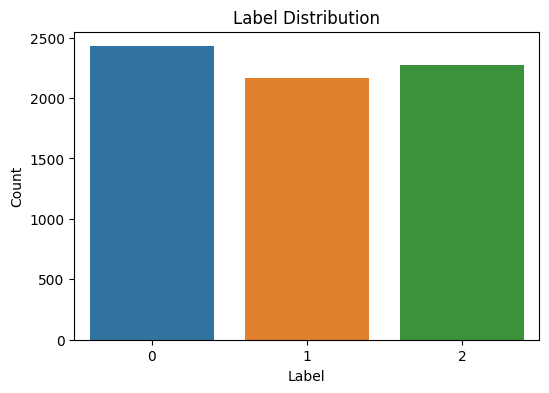

In [12]:
# Visualizing label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [13]:
print("\nUnique Labels:")
print(df['label'].unique())


Unique Labels:
[0 2 1]


### Text preprocessing pipeline
Preprocessing of Text Preprocessing:


* Removing html tags
* Removing Punctuations
* Performing Lemmatization
* Performing lowercase
* Removing Stopwords
* Decontracting words
* replacing special characters with their string symbols

nltk: Used for text preprocessing and lemmatization.

os: Helps in file operations like creating directories.

shutil: Used to copy files from one location to another.

wordnet: A lexical database for the English language (used for lemmatization).

omw-1.4: Supports multilingual WordNet access.

In [14]:
!pip install nltk

In [15]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [16]:
import nltk
import os
import shutil

# Download wordnet manually
nltk.download('wordnet')
nltk.download('omw-1.4')

# Find where wordnet is stored
nltk_data_path = os.path.join(nltk.data.find("corpora"), "wordnet.zip")

# Ensure nltk_data exists in the Kaggle working directory
kaggle_nltk_path = "/kaggle/working/nltk_data/corpora"
os.makedirs(kaggle_nltk_path, exist_ok=True)

# Copy wordnet to the Kaggle working directory
shutil.copy(nltk_data_path, kaggle_nltk_path)

# Extract wordnet.zip
import zipfile
with zipfile.ZipFile(os.path.join(kaggle_nltk_path, "wordnet.zip"), "r") as zip_ref:
    zip_ref.extractall(kaggle_nltk_path)

print("Wordnet successfully copied and extracted!")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
Wordnet successfully copied and extracted!


This defines a preprocessing function (preprocess(q)) to clean and normalize text data before training a machine learning model. and also import librbraires for that:

re – Regular expressions for cleaning text.

BeautifulSoup – Removes HTML tags.

word_tokenize – Splits sentences into words.

stopwords – Removes common words (e.g., "the", "is", "and").

wordnet – Used for lemmatization (converting words to base form).

WordNetLemmatizer – Performs lemmatization.

In [17]:
import re
import nltk
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# Ensure necessary NLTK resources are downloaded
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("stopwords")
nltk.download("punkt")

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess(q):
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # Remove '[math]' tag
    q = q.replace('[math]', '')

    # Convert large numbers to readable format
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontract words
    contractions = {
        "can't": "cannot", "won't": "will not", "i'm": "i am", "it's": "it is", 
        "he's": "he is", "she's": "she is", "they're": "they are", "we're": "we are",
        "you're": "you are", "i've": "i have", "we've": "we have", "they've": "they have",
        "who's": "who is", "what's": "what is", "where's": "where is", "when's": "when is",
        "how's": "how is", "he'd": "he would", "she'd": "she would", "they'd": "they would",
        "we'd": "we would", "i'd": "i would", "you'd": "you would", "it'd": "it would",
        "he'll": "he will", "she'll": "she will", "they'll": "they will", "we'll": "we will",
        "you'll": "you will", "i'll": "i will", "don't": "do not", "doesn't": "does not",
        "didn't": "did not", "haven't": "have not", "hasn't": "has not", "hadn't": "had not",
        "won't": "will not", "wouldn't": "would not", "shan't": "shall not", "shouldn't": "should not",
        "can't": "cannot", "couldn't": "could not", "mightn't": "might not", "mustn't": "must not"
    }
    
    q = ' '.join([contractions[word] if word in contractions else word for word in q.split()])
    
    # Removing HTML tags
    q = BeautifulSoup(q, "html.parser").get_text()

    # Tokenization
    tokens = word_tokenize(q)
    
    # Remove punctuations and stopwords, then lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]

    # Return cleaned text
    return " ".join(tokens)



[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
nltk.data.path.append("/kaggle/working/nltk_data")

This applies the preprocess() function to premise and hypothesis columns in the dataset.

In [19]:
df['premise'] = df['premise'].apply(preprocess)
df['hypothesis'] = df['hypothesis'].apply(preprocess)

<ipython-input-17-97fb760d0984>:57: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  q = BeautifulSoup(q, "html.parser").get_text()


In [20]:
df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,comment considered formulating interim rule,rule developed interim put together comment mind,en,English,0
1,5b72532a0b,issue wrestle practice group law firm said,practice group permitted work issue,en,English,2
2,5622f0c60b,know really defend like somebody grown uh say ...,defend age,en,English,0
3,fdcd1bd867,cockpit country ann bay,ann bay cockpit country,en,English,2
4,7cfb3d272c,look skin going trouble get busy,bos fire see slacking,en,English,1


This calculates the length of each premise and hypothesis (in characters) and stores the values in new columns.

In [21]:
df['premise_len'] = df['premise'].str.len() 
df['hypothesis_len'] = df['hypothesis'].str.len()

In [22]:
df.head()

,id,premise,hypothesis,lang_abv,language,label,premise_len,hypothesis_len
0,5130fd2cb5,comment considered formulating interim rule,rule developed interim put together comment mind,en,English,0,43,48
1,5b72532a0b,issue wrestle practice group law firm said,practice group permitted work issue,en,English,2,42,35
2,5622f0c60b,know really defend like somebody grown uh say ...,defend age,en,English,0,59,10
3,fdcd1bd867,cockpit country ann bay,ann bay cockpit country,en,English,2,23,23
4,7cfb3d272c,look skin going trouble get busy,bos fire see slacking,en,English,1,32,21


This calculates the number of words in premise and hypothesis and stores them in new columns.

In [23]:
df['premise_num_words'] = df['premise'].apply(lambda row: len(row.split(" ")))
df['hypothesis_num_words'] = df['hypothesis'].apply(lambda row: len(row.split(" ")))
df.head()

,id,premise,hypothesis,lang_abv,language,label,premise_len,hypothesis_len,premise_num_words,hypothesis_num_words
0,5130fd2cb5,comment considered formulating interim rule,rule developed interim put together comment mind,en,English,0,43,48,5,7
1,5b72532a0b,issue wrestle practice group law firm said,practice group permitted work issue,en,English,2,42,35,7,5
2,5622f0c60b,know really defend like somebody grown uh say ...,defend age,en,English,0,59,10,11,2
3,fdcd1bd867,cockpit country ann bay,ann bay cockpit country,en,English,2,23,23,4,4
4,7cfb3d272c,look skin going trouble get busy,bos fire see slacking,en,English,1,32,21,6,4


In [24]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['premise'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['hypothesis'].split(" ")))    
    return len(w1 & w2)

In [25]:
df['word_common'] = df.apply(common_words, axis=1)
df.head()

,id,premise,hypothesis,lang_abv,language,label,premise_len,hypothesis_len,premise_num_words,hypothesis_num_words,word_common
0,5130fd2cb5,comment considered formulating interim rule,rule developed interim put together comment mind,en,English,0,43,48,5,7,3
1,5b72532a0b,issue wrestle practice group law firm said,practice group permitted work issue,en,English,2,42,35,7,5,3
2,5622f0c60b,know really defend like somebody grown uh say ...,defend age,en,English,0,59,10,11,2,2
3,fdcd1bd867,cockpit country ann bay,ann bay cockpit country,en,English,2,23,23,4,4,4
4,7cfb3d272c,look skin going trouble get busy,bos fire see slacking,en,English,1,32,21,6,4,0


In [26]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['premise'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['hypothesis'].split(" ")))    
    return (len(w1) + len(w2))

In [27]:
df['word_total'] = df.apply(total_words, axis=1)
df.head()

,id,premise,hypothesis,lang_abv,language,label,premise_len,hypothesis_len,premise_num_words,hypothesis_num_words,word_common,word_total
0,5130fd2cb5,comment considered formulating interim rule,rule developed interim put together comment mind,en,English,0,43,48,5,7,3,12
1,5b72532a0b,issue wrestle practice group law firm said,practice group permitted work issue,en,English,2,42,35,7,5,3,12
2,5622f0c60b,know really defend like somebody grown uh say ...,defend age,en,English,0,59,10,11,2,2,12
3,fdcd1bd867,cockpit country ann bay,ann bay cockpit country,en,English,2,23,23,4,4,4,8
4,7cfb3d272c,look skin going trouble get busy,bos fire see slacking,en,English,1,32,21,6,4,0,10


In [28]:
df['word_share'] = round(df['word_common']/df['word_total'],2)
df.head()

,id,premise,hypothesis,lang_abv,language,label,premise_len,hypothesis_len,premise_num_words,hypothesis_num_words,word_common,word_total,word_share
0,5130fd2cb5,comment considered formulating interim rule,rule developed interim put together comment mind,en,English,0,43,48,5,7,3,12,0.25
1,5b72532a0b,issue wrestle practice group law firm said,practice group permitted work issue,en,English,2,42,35,7,5,3,12,0.25
2,5622f0c60b,know really defend like somebody grown uh say ...,defend age,en,English,0,59,10,11,2,2,12,0.17
3,fdcd1bd867,cockpit country ann bay,ann bay cockpit country,en,English,2,23,23,4,4,4,8,0.50
4,7cfb3d272c,look skin going trouble get busy,bos fire see slacking,en,English,1,32,21,6,4,0,10,0.00


Advanced Feature Extraction (NLP and Fuzzy Features)
Definition:

Token: You get a token by splitting sentence a space
Stop_Word : stop words as per NLTK.
Word : A token that is not a stop_word
Features:

cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
cwc_min = common_word_count / (min(len(q1_words), len(q2_words))


cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
cwc_max = common_word_count / (max(len(q1_words), len(q2_words))


csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2
csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))


csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))


ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))


ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))


last_word_eq : Check if First word of both questions is equal or not
last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])


first_word_eq : Check if First word of both questions is equal or not
first_word_eq = int(q1_tokens[0] == q2_tokens[0])


abs_len_diff : Abs. length difference
abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))


mean_len : Average Token Length of both Questions
mean_len = (len(q1_tokens) + len(q2_tokens))/2


fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [29]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    pre = row['premise']
    hypo = row['hypothesis']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    pre_tokens = pre.split()
    hypo_tokens = hypo.split()
    
    if len(pre_tokens) == 0 or len(hypo_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    pre_words = set([word for word in pre_tokens if word not in STOP_WORDS])
    hypo_words = set([word for word in hypo_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    pre_stops = set([word for word in pre_tokens if word in STOP_WORDS])
    hypo_stops = set([word for word in hypo_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(pre_words.intersection(hypo_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(pre_stops.intersection(hypo_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(pre_tokens).intersection(set(hypo_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(pre_words), len(hypo_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(pre_words), len(hypo_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(pre_stops), len(hypo_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(pre_stops), len(hypo_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(pre_tokens), len(hypo_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(pre_tokens), len(hypo_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(pre_tokens[-1] == hypo_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(pre_tokens[0] == hypo_tokens[0])
    
    return token_features

In [31]:
token_features = df.apply(fetch_token_features, axis=1)

df["cwc_min"]       = list(map(lambda x: x[0], token_features))
df["cwc_max"]       = list(map(lambda x: x[1], token_features))
df["csc_min"]       = list(map(lambda x: x[2], token_features))
df["csc_max"]       = list(map(lambda x: x[3], token_features))
df["ctc_min"]       = list(map(lambda x: x[4], token_features))
df["ctc_max"]       = list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [32]:
!pip install distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 4.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16256 sha256=761dc2336ede488eee075d367b733f507185f696cef26c92fcc58f77b4feff54
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance


In [33]:
import distance

def fetch_length_features(row):
    pre = str(row['premise'])  
    hypo = str(row['hypothesis'])

    pre_tokens = pre.split()
    hypo_tokens = hypo.split()

    length_features = [0] * 3
    length_features[0] = abs(len(pre_tokens) - len(hypo_tokens))
    length_features[1] = (len(pre_tokens) + len(hypo_tokens)) / 2

    strs = list(distance.lcsubstrings(pre, hypo))
    
    if strs:  
        length_features[2] = len(strs[0]) / (min(len(pre), len(hypo)) + 1)
    else:
        length_features[2] = 0 
    
    return length_features


length_features = df.apply(fetch_length_features, axis=1)


df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [34]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))
df.head()

,id,premise,hypothesis,lang_abv,language,label,premise_len,hypothesis_len,premise_num_words,hypothesis_num_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio
0,5130fd2cb5,comment considered formulating interim rule,rule developed interim put together comment mind,en,English,0,43,48,5,7,...,0.428565,0.0,0.0,0.599988,0.428565,0.0,0.0,2,6.0,0.204545
1,5b72532a0b,issue wrestle practice group law firm said,practice group permitted work issue,en,English,2,42,35,7,5,...,0.428565,0.0,0.0,0.599988,0.428565,0.0,0.0,2,6.0,0.416667
2,5622f0c60b,know really defend like somebody grown uh say ...,defend age,en,English,0,59,10,11,2,...,0.199998,0.0,0.0,0.999950,0.181817,0.0,0.0,9,6.5,0.636364
3,fdcd1bd867,cockpit country ann bay,ann bay cockpit country,en,English,2,23,23,4,4,...,0.999975,0.0,0.0,0.999975,0.999975,0.0,0.0,0,4.0,0.625000
4,7cfb3d272c,look skin going trouble get busy,bos fire see slacking,en,English,1,32,21,6,4,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,2,5.0,0.136364


In [35]:
!pip install python-Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 38.0 MB/s eta 0:00:0000:0100:01


In [36]:
!pip install fuzzywuzzy

In [37]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    pre = row['premise']
    hypo = row['hypothesis']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(pre, hypo)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(pre, hypo)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(pre, hypo)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(pre, hypo)

    return fuzzy_features

In [38]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [39]:
df.shape

(6870, 28)

In [40]:
df.head()

,id,premise,hypothesis,lang_abv,language,label,premise_len,hypothesis_len,premise_num_words,hypothesis_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,5130fd2cb5,comment considered formulating interim rule,rule developed interim put together comment mind,en,English,0,43,48,5,7,...,0.428565,0.0,0.0,2,6.0,0.204545,37,40,55,66
1,5b72532a0b,issue wrestle practice group law firm said,practice group permitted work issue,en,English,2,42,35,7,5,...,0.428565,0.0,0.0,2,6.0,0.416667,49,60,62,73
2,5622f0c60b,know really defend like somebody grown uh say ...,defend age,en,English,0,59,10,11,2,...,0.181817,0.0,0.0,9,6.5,0.636364,29,70,29,100
3,fdcd1bd867,cockpit country ann bay,ann bay cockpit country,en,English,2,23,23,4,4,...,0.999975,0.0,0.0,0,4.0,0.625000,65,79,100,100
4,7cfb3d272c,look skin going trouble get busy,bos fire see slacking,en,English,1,32,21,6,4,...,0.000000,0.0,0.0,2,5.0,0.136364,38,38,38,38


In [41]:
sen_df = df[['premise','hypothesis']]
sen_df.head()

,premise,hypothesis
0,comment considered formulating interim rule,rule developed interim put together comment mind
1,issue wrestle practice group law firm said,practice group permitted work issue
2,know really defend like somebody grown uh say ...,defend age
3,cockpit country ann bay,ann bay cockpit country
4,look skin going trouble get busy,bos fire see slacking


In [42]:
final_df = df.drop(columns=['id','premise','hypothesis','lang_abv',	'language'])
print(final_df.shape)
final_df.head()

(6870, 23)


,label,premise_len,hypothesis_len,premise_num_words,hypothesis_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,0,43,48,5,7,3,12,0.25,0.599988,0.428565,...,0.428565,0.0,0.0,2,6.0,0.204545,37,40,55,66
1,2,42,35,7,5,3,12,0.25,0.599988,0.428565,...,0.428565,0.0,0.0,2,6.0,0.416667,49,60,62,73
2,0,59,10,11,2,2,12,0.17,0.999950,0.199998,...,0.181817,0.0,0.0,9,6.5,0.636364,29,70,29,100
3,2,23,23,4,4,4,8,0.50,0.999975,0.999975,...,0.999975,0.0,0.0,0,4.0,0.625000,65,79,100,100
4,1,32,21,6,4,0,10,0.00,0.000000,0.000000,...,0.000000,0.0,0.0,2,5.0,0.136364,38,38,38,38


### TF-IDF (Term Frequency-Inverse Document Frequency) vectorization
to convert the text questions into numerical features.

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


questions = list(sen_df['premise']) + list(sen_df['hypothesis'])

tfidf = TfidfVectorizer(max_features=2000)


tfidf_matrix = tfidf.fit_transform(questions).toarray()

pre_arr, hypo_arr = np.vsplit(tfidf_matrix, 2)

In [44]:
temp_df1 = pd.DataFrame(pre_arr, index= sen_df.index)
temp_df2 = pd.DataFrame(hypo_arr, index= sen_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(6870, 4000)

In [45]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(6870, 4023)


,label,premise_len,hypothesis_len,premise_num_words,hypothesis_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0,43,48,5,7,3,12,0.25,0.599988,0.428565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,42,35,7,5,3,12,0.25,0.599988,0.428565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,59,10,11,2,2,12,0.17,0.999950,0.199998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,23,23,4,4,4,8,0.50,0.999975,0.999975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,32,21,6,4,0,10,0.00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model building and training

In [46]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)
print("X_train shape:", X_train.shape)  
print("X_test shape:", X_test.shape)

X_train shape: (5496, 4022)
X_test shape: (1374, 4022)


The percentage of data splitting in this code is 80% training data and 20% test data.

Decision Tree Classifier

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dt_model = DecisionTreeClassifier()  # Initialize Decision Tree model
dt_model.fit(X_train, y_train)  # Train the model

y_pred_dt = dt_model.predict(X_test)  # Make predictions
dt_accuracy = accuracy_score(y_test, y_pred_dt)  # Calculate accuracy

print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")

Decision Tree Accuracy: 0.40


Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Calculate accuracy
accuracy_score(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.450509461426492

Random Forest Classifier

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.44614264919941776

XGB Classifier

In [48]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [49]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)
accuracy_score(y_test,y_pred1)

0.4512372634643377

Logistic regression

In [50]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)
logreg_acc = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Accuracy: {logreg_acc:.4f}")


Logistic Regression Accuracy: 0.4782


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Model Creation:
ANN Model with Keras

In [51]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define ANN Model
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Print Model Summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.3265 - loss: 0.2306 - val_accuracy: 0.3231 - val_loss: 0.3405
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3303 - loss: 0.0788 - val_accuracy: 0.3311 - val_loss: -6.0480
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3217 - loss: -9.8212 - val_accuracy: 0.3231 - val_loss: -103.1022
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3363 - loss: -101.6141 - val_accuracy: 0.3231 - val_loss: -368.4622
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3255 - loss: -503.6275 - val_accuracy: 0.3231 - val_loss: -3764.2463
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3243 - loss: -5596.6294 - val_accuracy: 0.3224 - val_loss: -11890.7646
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3239 - loss: -11890.2393 - val_accuracy: 0.3370 - val_loss: -27774.3086
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │       2,059,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,672,389 (25.45 MB)

 Trainable params: 2,224,129 (8.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,448,260 (16.97 MB)

### LSTM for Sequence-Based Learning

In [52]:
from tensorflow.keras.layers import LSTM, Embedding

lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=X_train.shape[1]),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 60s 326ms/step - accuracy: 0.3104 - loss: 0.1358 - val_accuracy: 0.3231 - val_loss: 0.1519
Epoch 2/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 56s 324ms/step - accuracy: 0.3060 - loss: 0.0910 - val_accuracy: 0.3231 - val_loss: 0.1545
Epoch 3/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 56s 324ms/step - accuracy: 0.3114 - loss: 0.0923 - val_accuracy: 0.3231 - val_loss: 0.1574
Epoch 4/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 56s 324ms/step - accuracy: 0.3131 - loss: 0.0616 - val_accuracy: 0.3231 - val_loss: 0.1534
Epoch 5/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 56s 324ms/step - accuracy: 0.3176 - loss: -0.0395 - val_accuracy: 0.3231 - val_loss: 0.1535
Epoch 6/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 56s 324ms/step - accuracy: 0.3186 - loss: 0.0714 - val_accuracy: 0.3231 - val_loss: 0.1551
Epoch 7/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 56s 325ms/step - accuracy: 0.3065 - loss: 0.1617 - val_accuracy: 0.3231 - val_loss: 0.1643
Epoch 8/10
172/172 ━━━━━━━━━━━━━━━━━━━━ 56s 324ms/step - accuracy: 0.3104 - loss: 

### Model Evaluation
Evaluate Model with Accuracy, Precision, Recall, and F1-Score of random forest

Accuracy: 0.4425
Precision: 0.4349
Recall: 0.4425
F1 Score: 0.4355


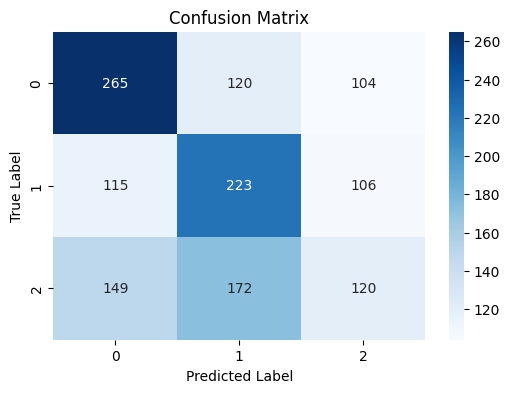

AUC Score: 0.6067


In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict Probabilities & Classes
y_pred_probs = rf.predict_proba(X_test)  # Use predict_proba for probability outputs
y_pred_classes = rf.predict(X_test)  # Predicted class labels

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average="weighted")  # Multiclass handling
recall = recall_score(y_test, y_pred_classes, average="weighted")
f1 = f1_score(y_test, y_pred_classes, average="weighted")

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_classes), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# AUC-ROC Curve for Multiclass
roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class="ovr")  # One-vs-Rest (OvR) AUC Score

print(f"AUC Score: {roc_auc:.4f}")


### Grid Search for Hyperparameter Optimization

In [54]:
!pip install keras-tuner

In [55]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential([
        Dense(hp.Int("units", 128, 512, step=128), activation="relu", input_shape=(X_train.shape[1],)),
        Dropout(hp.Choice("dropout", [0.3, 0.5])),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, directory="tuner_results"
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
best_model = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 00m 08s]
val_accuracy: 0.37772926688194275

Best val_accuracy So Far: 0.3806404769420624
Total elapsed time: 00h 00m 38s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


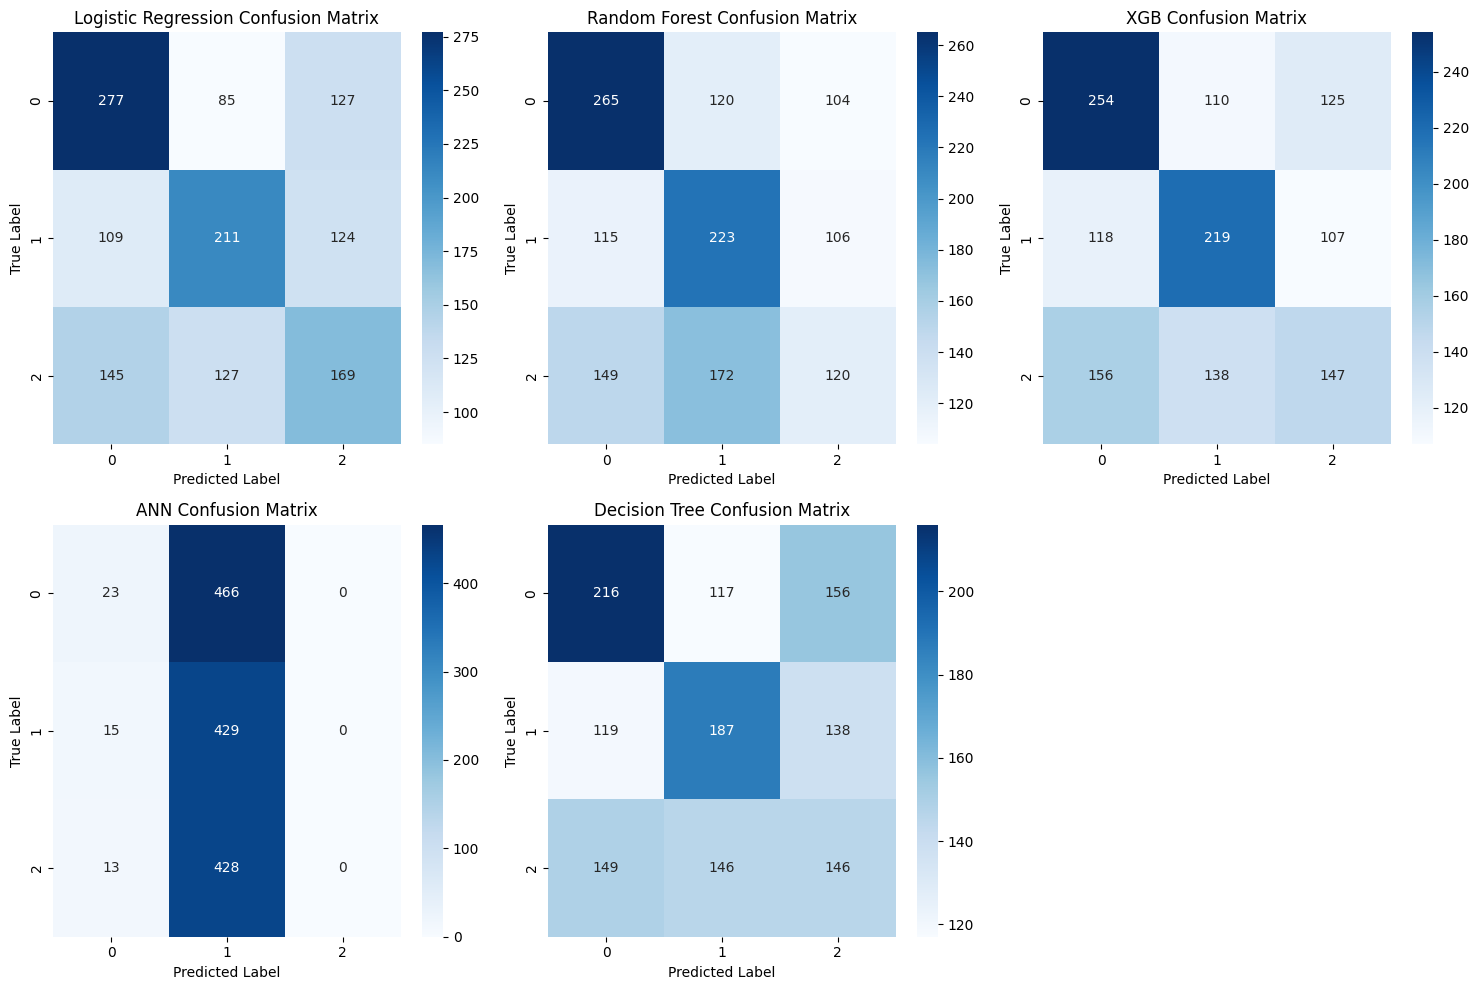

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Assuming you have trained these models
models = {
    "Logistic Regression": logreg,
    "Random Forest": rf,
    "XGB": xgb,
    "ANN": model,  # Your trained ANN (Keras/TensorFlow model)
    "Decision Tree": dt_model  # Your trained Decision Tree model
}

# Store evaluation metrics dynamically
conf_matrices = {}

for name, model in models.items():
    if name == "ANN":  
        y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()  # Convert ANN output to binary
    else:
        y_pred = model.predict(X_test)

    # Compute Confusion Matrix
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

# Determine grid size for plotting confusion matrices
num_models = len(models)
rows = (num_models // 3) + (num_models % 3 > 0)  # 2 rows for better visibility
cols = 3 if num_models > 3 else num_models  # Max 3 columns

# Plot Confusion Matrices in 2x3 Grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()  # Flatten for easier looping

for idx, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[idx])
    axes[idx].set_title(f"{name} Confusion Matrix")
    axes[idx].set_xlabel("Predicted Label")
    axes[idx].set_ylabel("True Label")

# Hide empty subplots if models are less than 6
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from tabulate import tabulate

# Assuming you have trained these models
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "XGB": xgb,
    "ANN": model,  # Your trained Keras/TensorFlow model
    "Decision Tree": dt_model  # Your trained Decision Tree model
}

# Store evaluation metrics dynamically
accuracy_scores = []
f1_scores = []

for name, model in models.items():
    if name == "ANN":  
        # ANN requires a different prediction format
        y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()  
    else:
        y_pred = model.predict(X_test)

    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average="weighted"))  # FIXED: Use "weighted" for multiclass

# Create DataFrame
df_scores = pd.DataFrame({"Model": models.keys(), "Accuracy": accuracy_scores, "F1-Score": f1_scores})

# Display results as a formatted table
table = tabulate(df_scores, headers="keys", tablefmt="fancy_grid")
print(table)


╒════╤═════════════════════╤════════════╤════════════╕
│    │ Model               │   Accuracy │   F1-Score │
╞════╪═════════════════════╪════════════╪════════════╡
│  0 │ Logistic Regression │   0.450509 │   0.449176 │
├────┼─────────────────────┼────────────┼────────────┤
│  1 │ Random Forest       │   0.442504 │   0.435483 │
├────┼─────────────────────┼────────────┼────────────┤
│  2 │ XGB                 │   0.451237 │   0.448213 │
├────┼─────────────────────┼────────────┼────────────┤
│  3 │ ANN                 │   0.393741 │   0.315467 │
├────┼─────────────────────┼────────────┼────────────┤
│  4 │ Decision Tree       │   0.399563 │   0.399578 │
╘════╧═════════════════════╧════════════╧════════════╛


### Transformer-Based Models (bert)

In [58]:
pip install transformers datasets torch scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import pandas as pd
import numpy as np
import re
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("/kaggle/input/mydearwason1/train.csv")

# Keep only English rows
df = df[df["language"] == "English"].reset_index(drop=True)

# Preprocessing function
def preprocess(text):
    text = str(text).lower().strip()
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)  # Remove special characters
    return text

# Apply text preprocessing
df['cleaned_premise'] = df['premise'].apply(preprocess)
df['cleaned_hypothesis'] = df['hypothesis'].apply(preprocess)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df[['cleaned_premise', 'cleaned_hypothesis']], df['label'], test_size=0.2, random_state=42
)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# Tokenization function
def tokenize_data(premises, hypotheses, labels):
    encodings = tokenizer(premises, hypotheses, padding=True, truncation=True, return_tensors="pt")
    return {**encodings, "labels": torch.tensor(labels)}

# Create dataset class
class SentenceDataset(Dataset):
    def __init__(self, premises, hypotheses, labels):
        self.encodings = tokenize_data(premises, hypotheses, labels)
    def __len__(self):
        return len(self.encodings["labels"])
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

# Prepare datasets
train_dataset = SentenceDataset(X_train['cleaned_premise'].tolist(), X_train['cleaned_hypothesis'].tolist(), y_train.tolist())
test_dataset = SentenceDataset(X_test['cleaned_premise'].tolist(), X_test['cleaned_hypothesis'].tolist(), y_test.tolist())

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Updated from deprecated "evaluation_strategy"
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,  # Increased epochs for better training
    weight_decay=0.01,
    learning_rate=2e-5,  # Set optimal learning rate
    logging_dir="./logs",
    save_strategy="epoch",  # Save model checkpoints each epoch
    report_to="none"  # Disable Weights & Biases logging if not needed
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train BERT model
trainer.train()

# Evaluate
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"BERT Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


In [1]:
def test_common_words(pre,hypo):
    w1 = set(map(lambda word: word.lower().strip(), pre.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), hypo.split(" ")))    
    return len(w1 & w2)

In [ ]:

def test_total_words(pre,hypo):
    w1 = set(map(lambda word: word.lower().strip(), pre.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), hypo.split(" ")))    
    return (len(w1) + len(w2))

In [ ]:
def test_fetch_token_features(pre,hypo):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    pre_tokens = pre.split()
    hypo_tokens = hypo.split()
    
    if len(pre_tokens) == 0 or len(hypo_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    pre_words = set([word for word in pre_tokens if word not in STOP_WORDS])
    hypo_words = set([word for word in hypo_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    pre_stops = set([word for word in pre_tokens if word in STOP_WORDS])
    hypo_stops = set([word for word in hypo_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(pre_words.intersection(hypo_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(pre_stops.intersection(hypo_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(pre_tokens).intersection(set(hypo_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(pre_words), len(hypo_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(pre_words), len(hypo_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(pre_stops), len(hypo_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(pre_stops), len(hypo_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(pre_tokens), len(hypo_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(pre_tokens), len(hypo_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(pre_tokens[-1] == hypo_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(pre_tokens[0] == hypo_tokens[0])
    
    return token_features

In [ ]:
def test_fetch_length_features(pre,hypo):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    pre_tokens = pre.split()
    hypo_tokens = hypo.split()
    
    if len(pre_tokens) == 0 or len(hypo_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(pre_tokens) - len(hypo_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(pre_tokens) + len(hypo_tokens))/2
    
    strs = list(distance.lcsubstrings(pre, hypo))
    length_features[2] = len(strs[0]) / (min(len(pre), len(hypo)) + 1)
    
    return length_features

In [ ]:
def test_fetch_fuzzy_features(pre,hypo):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(pre, hypo)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(pre, hypo)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(pre, hypo)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(pre, hypo)

    return fuzzy_features

In [ ]:
def query_point_creator(pre,hypo):
    
    input_query = []
    
    # preprocess
    pre = preprocess(pre)
    hypo = preprocess(hypo)
    
    # fetch basic features
    input_query.append(len(pre))
    input_query.append(len(hypo))
    
    input_query.append(len(pre.split(" ")))
    input_query.append(len(hypo.split(" ")))
    
    input_query.append(test_common_words(pre,hypo))
    input_query.append(test_total_words(pre,hypo))
    input_query.append(round(test_common_words(pre,hypo)/test_total_words(pre,hypo),2))
    
    # fetch token features
    token_features = test_fetch_token_features(pre,hypo)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(pre,hypo)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(pre,hypo)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    pre_bow = tfidf.transform([pre]).toarray()
    
    # bow feature for q2
    hypo_bow = tfidf.transform([hypo]).toarray()
    
    
    
    return np.hstack((np.array(input_query).reshape(1,22),pre_bow,hypo_bow))

In [ ]:
pre = 'This historically renowned freshwater lake, known both as the Sea of Galilee and Lake Kinneret (meaning a harp, after its shape), is just 58 km (36 miles) in circumference.'
hypo = 'The Sea of Galilee has also been known as Lake Kinneret for hundreds of years.'

In [ ]:

rf.predict(query_point_creator(pre,hypo))

In [48]:
import pickle

pickle.dump(rf,open('model.pkl','wb'))

In [ ]:
def bert_predict(premise, hypothesis):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check if GPU is available
    model.to(device)  # Ensure the model is on the right device

    inputs = tokenizer(premise, hypothesis, padding=True, truncation=True, return_tensors="pt")
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to the same device

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(**inputs)  # Get model outputs

    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()  # Get predicted class

    return predicted_class


In [ ]:
predicted_label = bert_predict(pre, hypo)
predicted_label

In [49]:
from sklearn.ensemble import RandomForestClassifier
import pickle

# Example training data


# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Save the model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import joblib

# Generate example training data
X_train, y_train = make_classification(n_samples=100, n_features=5, random_state=42)

# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Save the model using joblib
joblib.dump(model, 'model.joblib')

print("Model saved successfully using joblib!")


Model saved successfully using joblib!


In [51]:
import sklearn
print(sklearn.__version__)


1.2.2
